# Speech Signal Processing

A to Z for speech signal processing and natural language processing with speech dataset

## Reference
- [Librosa](http://librosa.github.io/librosa/) : Python library for speech signal processing
- [LJSpeech](https://keithito.com/LJ-Speech-Dataset/) : Single-speaker dataset usually used in research
- [Kyubyong](https://github.com/Kyubyong/tensorflow-exercises) : This repo. includes awesome codes for speech signal processing and tensorflow

In [1]:
import IPython.display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import librosa
import librosa.display

In [3]:
import os, sys
import numpy as np
import pandas as pd
import scipy
from tqdm import tnrange, tqdm_notebook

## Arguments

In [4]:
class Args:
    ''' arguments '''
    sr = 22050 # audio sampling rate. sr per sec
    fpath = './data/wavs/LJ043-0106.wav' # example audio file from LJSpeech
#     fpath = librosa.util.example_audio_file() # example audio in librosa library
    meta = './data/metadata.csv' # transcript file
    
    n_fft = 2048 # the number of fft length
    win_length = 1000 # window length in samples
    hop_length = 250 # hop in samples
    
    n_mels = 80 # the number of filters for mel-spectrogram
    
    emp_rate = 0.97 # preemphasis rate, hyperparmeter for preprocessing
    n_iter = 50 # for Griffin-Lim algorithm, invert STFT
    
args = Args()

## Data load

In [5]:
audio, sr = librosa.load(args.fpath, sr=args.sr)
audio.shape

(66717,)

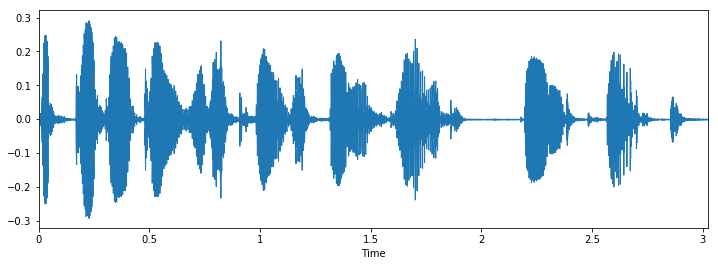

In [6]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(audio, sr)

In [7]:
IPython.display.Audio(audio, rate=sr)

You should use ipython to listen the audio file, not github preview.

In [8]:
meta = pd.read_csv(args.meta, header=None, sep='|')
meta.columns = ['fpath', 'text', 'normalized']
meta

,fpath,text,normalized
0,LJ043-0106,"it didn't do his case any good, end quote.","it didn't do his case any good, end quote."


In [9]:
meta.loc[0].text

"it didn't do his case any good, end quote."

## Spectrograms

<h4><center>Pre-emphasize</center></h4>
$$audio=[a_0,a_1,...,a_N]$$

$$audio[0]=[a_0]$$

$$audio[1:]=[a_1,a_2...,a_N]$$

$$audio[:-1]=[a_0,a_1,...,a_{N-1}]$$

$$audio_{emp}=[audio[0], audio[1:]-0.97*audio[:-1]]$$

In [10]:
_audio = np.append(audio[0], audio[1:] - args.emp_rate*audio[:-1])

In [11]:
linear = librosa.stft(_audio, n_fft=args.n_fft, win_length=args.win_length, hop_length=args.hop_length)
mag = np.abs(linear) # magnitude spectrogram removed complex numbers
mag.shape

(1025, 267)

In [12]:
mel_basis = librosa.filters.mel(args.sr, args.n_fft, args.n_mels)
mel = np.dot(mel_basis, mag) # mel-spectrogram
mel_basis.shape, mel.shape

((80, 1025), (80, 267))

In [13]:
print('mel basis range: [{:.2f}, {:.4f}]'.format(mel_basis.min(), mel_basis.max()))
print('mel spectrogram range: [{:.7f}, {:.4f}]'.format(mel.min(), mel.max()))
print('mag spectrogram range: [{:.7f}, {:.4f}]'.format(mag.min(), mag.max()))
print('linear spectrogram range: [{:.2f}, {:.2f}]'.format(linear.min(), linear.max()))

mel basis range: [0.00, 0.0241]
mel spectrogram range: [0.0000125, 0.7343]
mag spectrogram range: [0.0000003, 20.5412]
linear spectrogram range: [-16.59-1.92j, 18.10-1.50j]


In [14]:
# to dB, 20*log_10(S/ref)
db_mel = librosa.amplitude_to_db(mel, ref=np.max)
db_mag = librosa.amplitude_to_db(mag, ref=np.max)

In [15]:
[db_mel.min(), db_mel.max()], [db_mag.min(), db_mag.max()]

([-80.0, 0.0], [-80.0, 0.0])

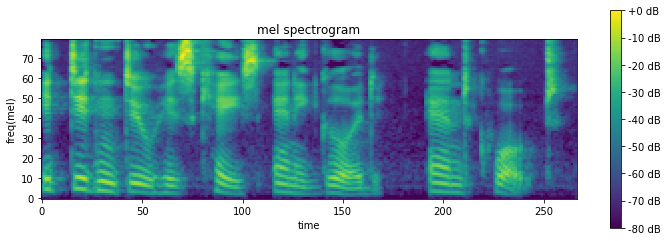

In [16]:
plt.figure(figsize=(12, 4))
plt.imshow(db_mel)
plt.title('mel spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.ylabel('freq(mel)')
plt.xlabel('time')
plt.gca().invert_yaxis()
plt.show()

In [18]:
np.mean(db_mag == np.repeat(db_mag, 2, axis=1)[:,::2]), np.mean(db_mag == np.repeat(db_mag, 2, axis=1)[:,1::2])

(1.0, 1.0)

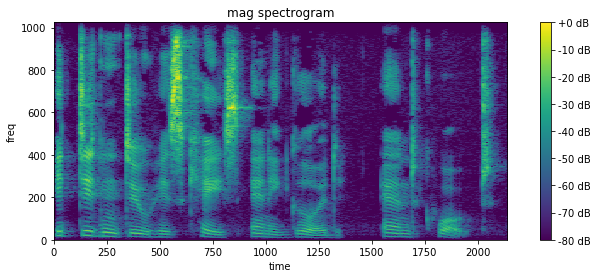

In [19]:
db_mag = np.repeat(db_mag, 8, axis=1) # repeatedly expanded for visualization
plt.figure(figsize=(12, 4))
plt.imshow(db_mag)
plt.title('mag spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.ylabel('freq')
plt.xlabel('time')
plt.gca().invert_yaxis()
plt.show()

In [20]:
fname = os.path.basename(args.fpath)
fname

'LJ043-0106.wav'

In [21]:
# save the data preprocessed
print('already exists path') if os.path.exists('./data/mels') else os.makedirs('./data/mels')
print('already exists path') if os.path.exists('./data/mags') else os.makedirs('./data/mags')
np.save('./data/mels/{}'.format(fname.replace('wav', 'npy')), mel)
np.save('./data/mags/{}'.format(fname.replace('wav', 'npy')), mag)
print('saved spectrograms')

already exists path
already exists path
saved spectrograms


## Spectrogram to Wav (Griffin-Lim)

In [22]:
import copy

In [23]:
sp_best = copy.deepcopy(mag)

for i in tnrange(args.n_iter):
    sp = librosa.istft(sp_best, args.hop_length, args.win_length)
    est = librosa.stft(sp, args.n_fft, args.hop_length, args.win_length)
    phase = est / np.maximum(1e-8, np.abs(est))
    sp_best = mag * phase

sp = librosa.istft(sp_best, args.hop_length, args.win_length)
est_audio = np.real(sp)
# de-pre-emphsize
est_audio = scipy.signal.lfilter([1], [1, -args.emp_rate], est_audio)
est_audio.shape, audio.shape

((66500,), (66717,))

## Comparison of original audio and estimated audio

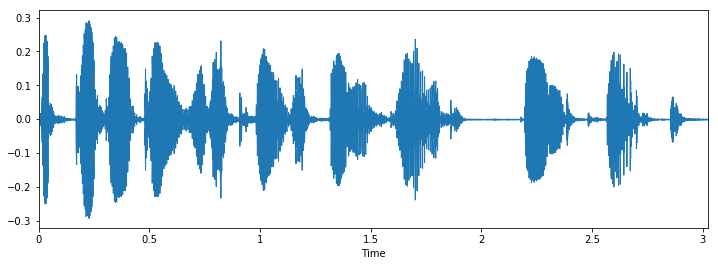

In [24]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(audio, args.sr)

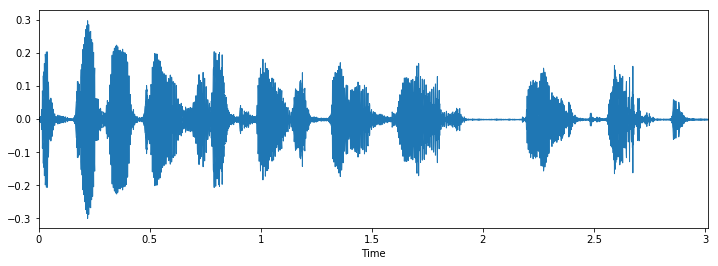

In [25]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(est_audio, args.sr)

In [26]:
IPython.display.Audio(audio, rate=args.sr)

In [27]:
IPython.display.Audio(est_audio, rate=args.sr)